# Estimating Soil Propeties 3D Models Using Pretrained Weights

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### **Estimated Area**

In [16]:
X_TEST_START = 549648
X_TEST_STOP = 549751
X_STEP = 10

Y_TEST_START = 213758
Y_TEST_STOP = 213833
Y_STEP = 10

ELEVATION_START = 80
ELEVATION_STOP = 145
ELEVATION_STEP = 5

# model_type = 'probabilistic'
model_type = 'deterministic'

### Load data

In [17]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [18]:
# Specific soil types
assign_num_list = {'uncertain': 9,
                    'topsoil layer': 8,
                    'reclaimed layer': 7,
                    'sedimentary layer': 6,
                    'colluvial layer': 5,
                    'weathered soil': 4,
                    'weathered rock': 3,
                    'soft rock': 2,
                    'moderate rock': 1,
                     'hard rock': 0,
                  }

In [19]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# Load Pretrained Weights - *Check regression_models.ipynb file for model architecture*

In [20]:
def create_model(dim):
    model = Sequential([
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    return model

In [21]:
tfd = tfp.distributions
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
        )
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

model_prob = Sequential([
    tfpl.DenseVariational(units=20,
                          input_shape=(3,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_prob.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.001))
# model_prob.summary()

### Get best weights from deterministic or probabilistic model

In [22]:
def get_model_best_epoch(model, model_type):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}/checkpoint".format(model_type)
    
    model.load_weights(checkpoint_path)
    
    return model

In [23]:
if model_type == 'deterministic':
    print('===== Processing in deterministic type =====')
    model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic')
else:
    print('===== Processing in probabilistic type =====')
    model = get_model_best_epoch(model = model_prob, model_type='probabilistic')

===== Processing in deterministic type =====


# Create Estimated Data Points

In [24]:
def test_area_generate():
    test_area = np.empty((0,3), int)
    row = np.array([])
    for x in tqdm(range(X_TEST_START, X_TEST_STOP,X_STEP)):
        for y in range(Y_TEST_START, Y_TEST_STOP,Y_STEP):
            for elevation in range(ELEVATION_START, ELEVATION_STOP, ELEVATION_STEP):
                row = np.array([x,y,elevation])
                row = np.expand_dims(row,axis=0)
    #             print(row.shape)
                test_area = np.append(test_area, row, axis = 0)
#             print('Locationx: {}, y: {}, elevation: {}'.format(x,y,elevation))
    return test_area

In [25]:
X_test = test_area_generate()

100%|██████████| 11/11 [00:00<00:00, 321.50it/s]


In [26]:
normalized_X_test = normalizer.fit_transform(X_test)

In [27]:
def estimate_soil_properties(model, test_area):
    results = []
    for i in tqdm(range(len(test_area))):
        test_location = normalized_X_test[i]
        test_location = np.expand_dims(test_location, axis =0)
        result = model.predict(test_location)
#         print(result)
        results.append(int(result)-1)
    return np.array(results)

In [28]:
y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

 20%|██        | 233/1144 [00:05<00:22, 40.04it/s]

100%|██████████| 1144/1144 [00:30<00:00, 37.80it/s]


In [29]:
y_estimate[y_estimate < 0] = 9
y_estimate[y_estimate > 8] = 9

# 3D Estimated Points Visualization

In [30]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [31]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [32]:
label_colours = ['black', 'brown', 'red', 'magenta',
                'pink', 'yellow', 'green',
                'blue','cyan','silver']

# ANN Results

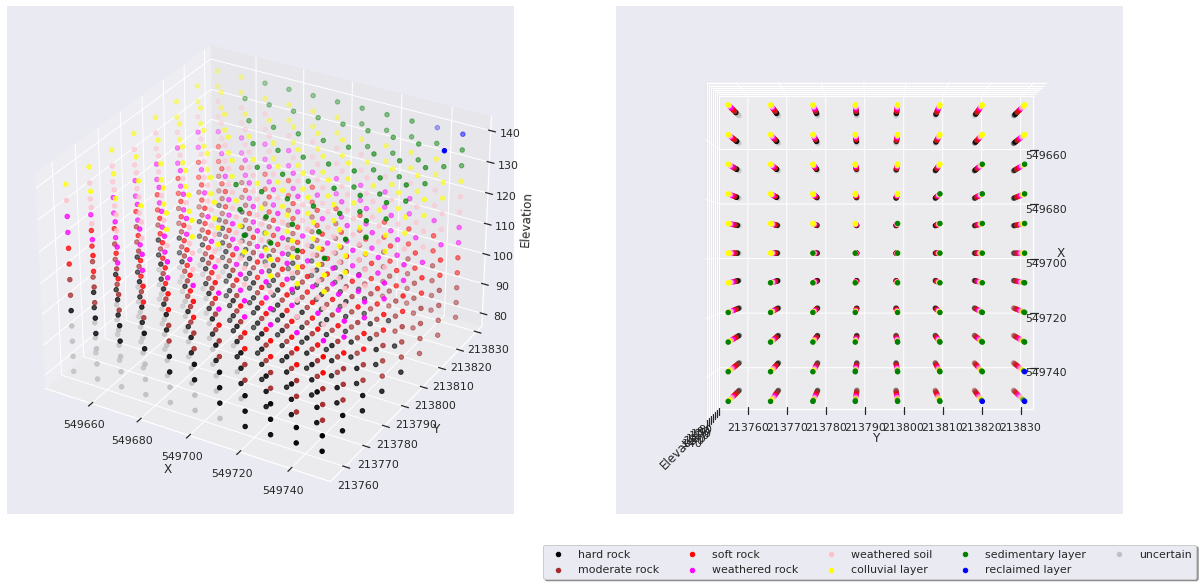

In [33]:
plot_data(X_test, y_estimate, labels, label_colours)
plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/estimated.png')
plt.show()

## Generate .csv

In [34]:
data_csv = pd.DataFrame({'X': X_test[:,0],
                        'Y': X_test[:,1],
                        'Elevation': X_test[:,2],
                        'Target': y_estimate})

In [35]:
data_csv

,X,Y,Elevation,Target
0,549648,213758,80,9
1,549648,213758,85,9
2,549648,213758,90,9
3,549648,213758,95,9
4,549648,213758,100,0
...,...,...,...,...
1139,549748,213828,120,4
1140,549748,213828,125,5
1141,549748,213828,130,6
1142,549748,213828,135,6


In [36]:
data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe.csv', index = False)

# BNN Results

In [37]:
model_type = 'probabilistic'

In [38]:
if model_type == 'deterministic':
    print('===== Processing in deterministic type =====')
    model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic')
else:
    print('===== Processing in probabilistic type =====')
    model = get_model_best_epoch(model = model_prob, model_type='probabilistic')

===== Processing in probabilistic type =====


In [39]:
y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

 33%|███▎      | 382/1144 [00:09<00:18, 40.95it/s]

100%|██████████| 1144/1144 [00:29<00:00, 39.30it/s]


In [40]:
y_estimate[y_estimate < 0] = 9
y_estimate[y_estimate > 8] = 9

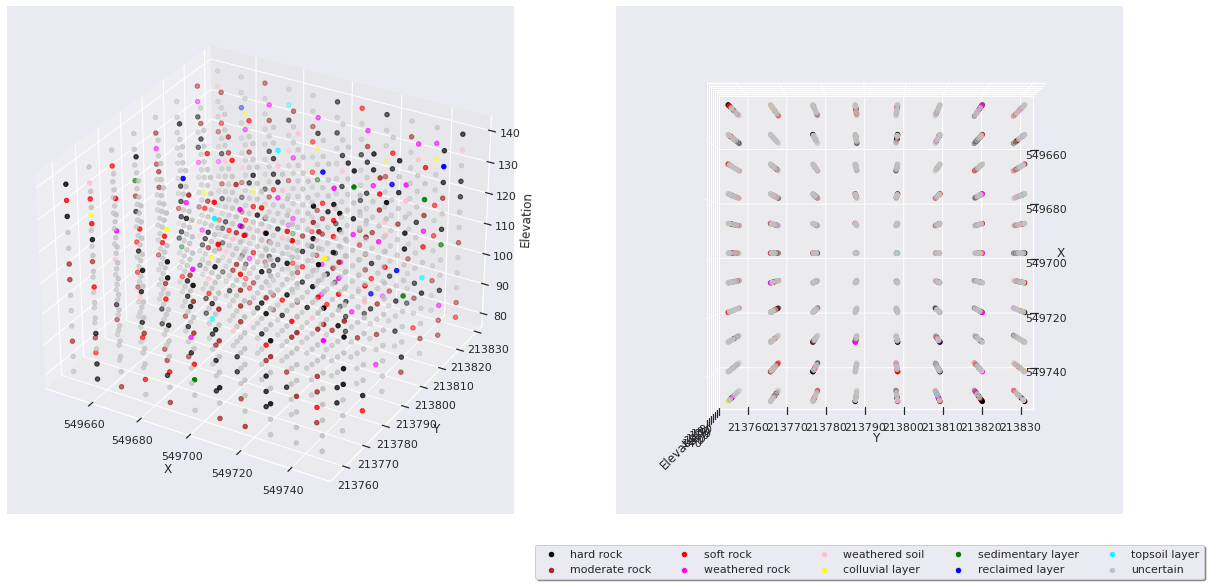

In [41]:
plot_data(X_test, y_estimate, labels, label_colours)
plt.show()